# Learner

This notebook contains the source code for the Learner module in the MiniAI framework.

In [ ]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
#| default_exp learner

In [ ]:
#| export
import math, torch, matplotlib.pyplot as plt, numpy as np
from operator import itemgetter
import fastcore.all as fc

from torch import tensor, nn, optim
from torch.utils.data import DataLoader, default_collate
import torch.nn.functional as F

from datasets import load_dataset, load_dataset_builder
from tqdm import tqdm

import torchvision.transforms.functional as TF
from fastcore.test import test_close
from contextlib import contextmanager
from functools import partial

from operator import attrgetter,itemgetter
from torcheval.metrics import *

import pandas as pd
from miniai.conv import *
from miniai.datasets import *
from nbdev.showdoc import *

from fastprogress.fastprogress import master_bar, progress_bar

In [ ]:
#| hide
torch.set_printoptions(precision=2, linewidth=140, sci_mode=False)
torch.manual_seed(1)

<torch._C.Generator>

In [ ]:
#| hide
name = 'fashion_mnist'
dsd = load_dataset(name)
dsd

Found cached dataset fashion_mnist (/Users/olly/.cache/huggingface/datasets/fashion_mnist/fashion_mnist/1.0.0/8d6c32399aa01613d96e2cbc9b13638f359ef62bb33612b077b4c247f6ef99c1)


  0%|          | 0/2 [00:00<?, ?it/s]

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 60000
    })
    test: Dataset({
        features: ['image', 'label'],
        num_rows: 10000
    })
})

In [ ]:
#| hide
@inplace
def transform(b): b['image'] = [TF.to_tensor(i) for i in b['image']]

In [ ]:
#| hide
tds = dsd.with_transform(transform)

In [ ]:
#| hide
dls = DataLoaders.from_dd(tds, batch_size=256)
b = next(iter(dls.train))
xb, yb = b
xb.shape, yb.shape

(torch.Size([256, 1, 28, 28]), torch.Size([256]))

In [ ]:
#| hide
def get_model():
    return nn.Sequential(
        ConvNormAct(1, 4),                 #14x14
        ConvNormAct(4, 8),                 #7x7
        ConvNormAct(8, 16),                #4x4
        ConvNormAct(16, 32),               #2x2
        ConvNormAct(32, 64),               #1x1
        nn.Flatten(),
        nn.Linear(64, 10),
    )

## Exceptions

In [ ]:
#| export
class CancelFitException(Exception): pass
class CancelBatchException(Exception): pass
class CancelEpochException(Exception): pass
class CancelFull_EpochException(Exception): pass

## Learner class

In [ ]:
#| export
from torch.optim import lr_scheduler

In [ ]:
#| export
class Learner:
    """
        Main flexible learner class that enables modular functionality to be added on.
        It does so with a context manager, which wraps function calls with 'before' and 
        'after' callbacks, within which functionality can be added.
    """
    def __init__(
        self, 
        dls, # Dataloaders object, expected as a tuple of (train, valid)
        model, # Model used for training
        opt_func=optim.SGD, # Optimisation function for optimising parameters after backprop, defaults to SGD
        scheduler=None, # Scheduler for adjusting the learning rate. Default 1Cycle
        loss_func=F.cross_entropy, # Loss function used, defaults to cross entropy
        cbs: list=None # Optional list of callback functions called via context manager
    ):
        fc.store_attr()
        if cbs is not None:
            for cb in cbs: cb.learn = self
        
    @contextmanager
    def callback_context(self, name):
        try:
            self.callback(f"before_{name}")
            yield
            self.callback(f"after_{name}")
        except globals()[f'Cancel{name.title()}Exception']: pass
        
    def fit(self, lr, epochs, lr_find=False):
        self.lr, self.n_epochs, self.epochs = lr, epochs, range(epochs)
        self.opt = self.opt_func(self.model.parameters(), self.lr)
        if self.scheduler is not None and not lr_find: 
            self.cbs = self.cbs + [self.scheduler]
            for cb in self.cbs: cb.learn = self
        with self.callback_context('fit'):
            for self.epoch in self.epochs:
                with self.callback_context('full_epoch'):
                    self._one_epoch(train=True)
                    self._one_epoch(train=False)
        
    def _one_epoch(self, train):
        self.model.training = train
        if train: self.dl = self.dls.train
        else: self.dl = self.dls.valid
        with self.callback_context('epoch'):
            for self.batch in self.dl:
                with self.callback_context('batch'):
                    self._one_batch()
        
    def _one_batch(self):
        self.xb, self.yb = self.batch
        self.predict()
        self.get_loss()
        if self.model.training:
            self.backward()
            self.step()
            self.zero_grad()
            
    def lr_find(self, lr_start=0.00001, gamma=1.3):
        lrf = LRFinderCB(gamma)
        lrf.learn = self
        self.cbs = self.cbs + [lrf]
        self.fit(lr_start, 1, lr_find=True)
        del(self.cbs[-1])
            
    def callback(self, name): 
        if self.cbs is not None:
            for cb in sorted(self.cbs, key=attrgetter('order')): 
                method = getattr(cb, name, None)
                if method is not None: method()

## Callbacks

In [ ]:
#| export
class Callback(): 
    """
        Base callback class establishing that callbacks can have an order.
        Callbacks inherit from this class and optionally update the order 
        parameter, to enable sequential ordering of callback functions that 
        depend on each other.
    """
    order = 0

### Metrics

In [ ]:
#| export
def to_cpu(b):
    """
        Returns data to the CPU.
    """
    if isinstance(b, list): return [to_cpu(o) for o in b]
    if isinstance(b, tuple): return tuple(to_cpu(list(b)))
    return b.detach().cpu()

In [ ]:
#| export
class MetricsCB(Callback):
    """
        Establishes and calculates metrics for training, and prints them
        out at the end of each epoch. Metrics include train loss, validation
        loss and optional metrics from the `torcheval` library.
    """
    def __init__(self, *ms, **metrics):
        for o in ms: metrics[type(o).__name__] = o
        self.metrics = metrics
        self.all_metrics = metrics
        self.all_metrics['loss'] = Mean()
        
    def _log(self): 
        if fc.IN_NOTEBOOK:
            from IPython.display import Markdown
            if self.epoch == 0: return Markdown('|Epoch|Train Loss|Valid Loss|Accuracy|\n|--|--|--|--|--|\n')
            return Markdown(f'|{self.learn.epoch}|{self.train_loss}|{valid_loss}|{}|\n|--|--|--|--|--|\n')
        else: print(self.log)
    
    def before_fit(self):
        self.learn.metrics = self
    def before_full_epoch(self):
        # self.log = '|Epoch|Train Loss|Valid Loss|Accuracy|\n|--|--|--|--|--|\n'
    def before_epoch(self): [o.reset() for o in self.all_metrics.values()]
    def after_batch(self):
        x, y = to_cpu(self.learn.batch)
        self.metrics['accuracy'].update(to_cpu(self.learn.preds), y)
        self.metrics['loss'].update(to_cpu(self.learn.loss), weight=len(x))
    def after_epoch(self):
        if self.learn.model.training: self.train_loss = round(float(self.all_metrics['loss'].compute().detach()), 4)
        if not self.learn.model.training: 
            self.valid_loss = round(float(self.all_metrics['loss'].compute().detach()), 4)
            self.accuracy = round(float(self.all_metrics['accuracy'].compute().detach()), 4)
            # self.log = f'|{self.learn.epoch}|{self.train_loss}|{valid_loss}|{}|\n|--|--|--|--|--|\n'
    def after_full_epoch(self):
        # log = {k:f"{v.compute():.3f}" for k, v in self.all_metrics.items()}
        self._log()

### Progress

In [ ]:
#| export
class ProgressCB(Callback):
    """
        Handles progress bars during training, and an optional plot parameter 
        plots the change in loss across training steps.
    """
    order = MetricsCB.order + 1
    def __init__(
        self, 
        plot=False # If true, plots the change in loss across training steps
    ): 
        self.plot = plot
        if plot: self.losses, self.counter = [], 0
        
    def before_fit(self): self.learn.epochs = master_bar(self.learn.epochs, total=self.learn.n_epochs)
    
    def before_epoch(self):
        self.learn.dl = progress_bar(self.learn.dl, leave=False, total=len(self.learn.dl))
    def after_batch(self):
        if self.plot and self.learn.model.training:
            self.losses.append(float(self.learn.loss.detach()))
            self.counter += 1
    
    def after_fit(self):
        if self.plot:
            self._plot()
            
    def _plot(self):
        fig, ax = plt.subplots(figsize=(4, 4))
        ax.plot(range(self.counter), self.losses)
        ax.set_title('Change in loss')
        ax.set_xlabel('Steps')
        ax.set_ylabel('Loss')

### Send to device

In [ ]:
#| export
def get_device():
    """
        Returns the available device in the current environment as
        a string.
    """
    if torch.backends.mps.is_available(): device = 'mps' 
    if torch.cuda.is_available(): device = 'cuda'
    else: device = 'cpu'
    return device

In [ ]:
#| export
class DeviceCB(Callback):
    """
        Sends both the model and batch data to the device.
    """
    def __init__(self): self.device = get_device()
    def before_fit(self): self.learn.model.to(self.device)
    def before_batch(self): 
        xb, yb = self.learn.batch
        self.learn.batch = (xb.to(self.device), yb.to(self.device))

### Base Learner subclass

In [ ]:
#| export
class BaseLearner(Learner):
    """
        Flexible training subclass that handles key training functionality
        for each batch.
    """
    def predict(self): self.preds = self.model(self.xb)
    def get_loss(self): self.loss = self.loss_func(self.preds, self.yb)
    def backward(self): self.loss.backward()
    def step(self): self.opt.step()
    def zero_grad(self): self.opt.zero_grad()

   Train loss  Valid loss  Accuracy
0      0.5202      0.4354     0.839


   Train loss  Valid loss  Accuracy
1      0.3549      0.3867    0.8522


   Train loss  Valid loss  Accuracy
2       0.322      0.3617    0.8654


   Train loss  Valid loss  Accuracy
3      0.3015      0.3511    0.8695


   Train loss  Valid loss  Accuracy
4      0.2866      0.3433    0.8742


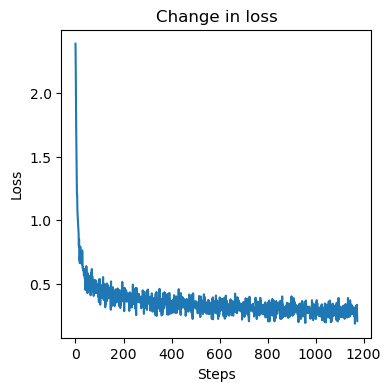

In [ ]:
cbs = [MetricsCB(accuracy=MulticlassAccuracy()), ProgressCB(plot=True), DeviceCB()]
model = get_model()
learn = BaseLearner(dls, model, cbs=cbs)
learn.fit(0.2, 5)

## Momentum

In [ ]:
#| export
class MomentumLearner(BaseLearner):
    """
        Training subclass which implements momentum in a memory-efficient
        way. Gradient updates are calculated directly in the tensor gradient, 
        and thus avoids storing a history of gradient updates.
    """
    def __init__(self, dls, model, opt_func=optim.SGD, loss_func=F.cross_entropy, cbs=None, mom=0.85): 
        self.mom = mom
        super().__init__(dls, model, opt_func=opt_func, loss_func=loss_func, cbs=cbs)
    def zero_grad(self):
        with torch.no_grad():
            for p in self.model.parameters(): p.grad *= self.mom

In [ ]:
cbs = [MetricsCB(accuracy=MulticlassAccuracy()), ProgressCB(plot=True), DeviceCB()]
model = get_model()
learn = MomentumLearner(dls, model, cbs=cbs)
learn.fit(0.2, 5)

## LR Finder

In [ ]:
#| export
from torch.optim.lr_scheduler import ExponentialLR

In [ ]:
#| export
class LRFinderCB(Callback):
    """
        Finds a suitable learning rate for the training data, by
        implementing Leslie Smith's learning rate finder algorithm. The
        learning rate is increased exponentially by a scalar until the loss 
        skyrockets, and a graph of loss vs. learning rate is returned.
    """
    def __init__(self, gamma=1.3): self.gamma = gamma
    def before_fit(self): 
        self.lrs, self.losses = [], []
        self.min = math.inf
        self.sched = ExponentialLR(self.learn.opt, self.gamma)
        
    def after_batch(self):
        if not self.learn.model.training: raise CancelEpochException()
        self.lrs.append(self.learn.opt.param_groups[0]['lr'])
        loss = to_cpu(self.learn.loss)
        self.losses.append(loss)
        if loss < self.min: self.min = loss
        if loss > self.min*3: 
            plt.plot(self.lrs, self.losses)
            plt.xscale('log')
            plt.xlabel('Learning Rate')
            plt.ylabel('Loss')
            raise CancelFitException()
        self.sched.step()

In [ ]:
cbs = [DeviceCB(), MetricsCB(accuracy=MulticlassAccuracy()), ProgressCB(), LRFinderCB()]
model = get_model()
learn = MomentumLearner(dls, model, cbs=cbs)
learn.fit(0.001, 1)

In [ ]:
cbs = [DeviceCB(), MetricsCB(accuracy=MulticlassAccuracy()), ProgressCB()]
model = get_model()
learn = BaseLearner(dls, model, cbs=cbs)
learn.lr_find()

## LR Scheduler

In [ ]:
#| hide
import nbdev; nbdev.nbdev_export()